# Gaussian Distribution tests

This notebook looks at the time it takes to create kernal density estimations with KDEpy, sklearn, and statsmodels.

In [1]:
import KDEpy
from KDEpy.utils import cartesian
import sklearn.neighbors
import statsmodels.nonparametric.kernel_density as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
import resource
#resource.setrlimit(resource.RLIMIT_AS, (2048, 2048))

In [2]:
def gaussian_kdes(sample_sizes, dims, bws, N=1, kernal="gaussian"):
    testing = pd.DataFrame(columns=["method", "sample_size", "dim", "bw",
                                    "time", "sd_time", "success"])
    methods = ["kdepy", "sklearn", "statsmodels"]
    
    for sample_size in sample_sizes:
        for dim in dims:
            for bw in bws:
                for method in methods:
                    total_time = []
                    sample = int(np.ceil(sample_size**(1/dim))**dim)
                    data = np.random.randn(sample, dim)
                    grid = np.meshgrid(*(np.linspace(-10, 10, np.ceil(sample_size**(1.0/float(dim)))),)*dim)
                    grid = np.reshape(grid, np.shape(data))
                    for n in range(N):
                        start = time.time()
                        try:
                            if method == "kdepy":
                                kde = KDEpy.FFTKDE(kernel=kernal, bw=bw, norm=2)
                                points = kde.fit(data).evaluate(grid)
                                success = 1
                            elif method == "sklearn":
                                grid = np.linspace(-10, 10, num=2**10)
                                kde = sklearn.neighbors.KernelDensity(kernel=kernal,
                                                                      bandwidth = bw)
                                kde.fit(data.reshape(-1, 1))
                                y = np.exp(kde.score_samples(grid.reshape(-1, 1)))
                                succuss = 1
                            elif method == "statsmodels":
                                kde = sm.KDEMultivariate(data,
                                                         var_type="c"*dim)
                                kde = kde.pdf(grid)
                                success = 1
                        except MemoryError:
                            success = 0
                        end = time.time()
                        total_time.append(end - start)
                        testing = testing.append(
                            pd.DataFrame({"method": method,
                                          "sample_size" : int(sample),
                                          "dim" : int(dim),
                                          "bw" : bw,
                                          "time": np.mean(end - start),
                                          "sd_time": np.std(total_time),
                                          "success": success}, index=[0]), ignore_index=True)                       
    return testing

In [3]:
sample_sizes = [10**i for i in range(2, 5)]
dims = list(range(2,7))
bws = [10**i for i in range(-1, 2)]

testing = gaussian_kdes(sample_sizes, dims, bws, N=1)

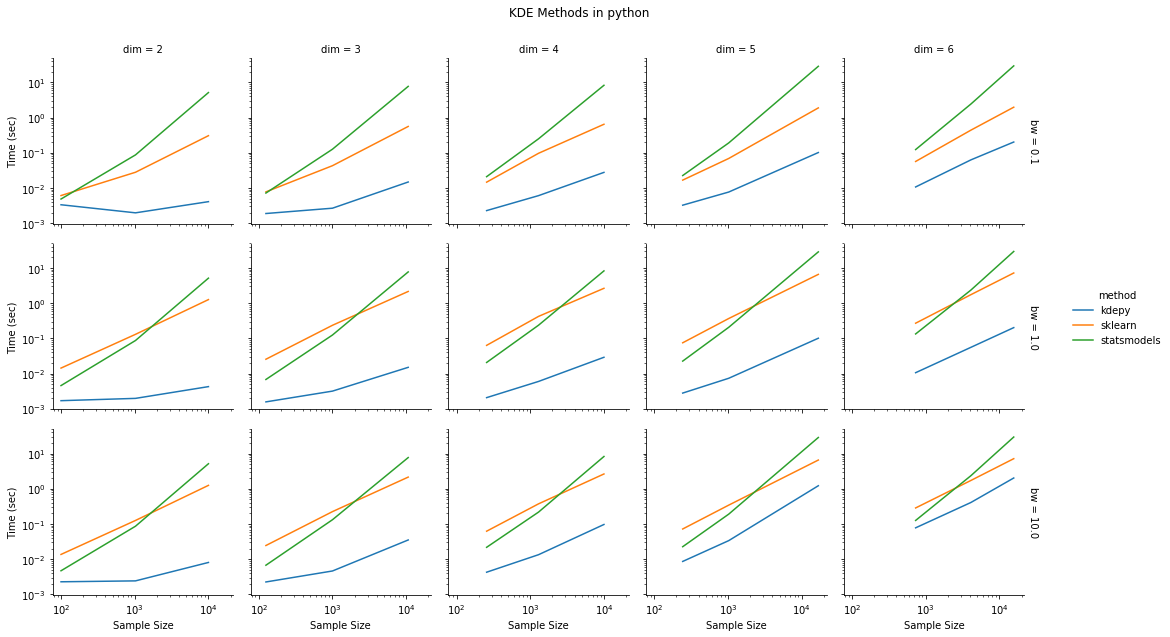

In [4]:
# TODO confidence intervals
g = sns.FacetGrid(testing, hue="method", row="bw", col="dim", margin_titles=True);
g.map(plt.loglog, "sample_size", "time");
g.add_legend();
plt.subplots_adjust(top=0.9);
g.fig.suptitle('KDE Methods in python');
_ = [g.axes[i,0].set_ylabel("Time (sec)") for i in range(len(bws))]
_ = [g.axes[len(bws)-1,i].set_xlabel("Sample Size") for i in range(len(dims))]